### Image Segmentation for Weather Forecasting

[Image segmentation is an important step in weather forecasting](http://goo.gl/Ytem38),
and should be performed on many high definition images on a daily basis. In such a use-case,interactive GPU programming would allow the applications designer to leverage powerful graphics processing on the GPU with little or no code changes from his original prototype. The application used the K-means algorithm which can easily be expressed in Julia and accelerated by ArrayFire.
It initializes some random clusters
and then reassigns the clusters according to Manhattan distances.

In [2]:
using ArrayFire
using Images

In [3]:
function kmeans(in::AFArray, k::Integer, image::AbstractString, img::AFArray, iter::Integer = 10)

    n = size(in, 1)
    d = size(in, 3)

    data = in * 0
    mini = minimum(in, 1)
    maxi = maximum(in, 1)

    mini  = reshape(mini, 1, 1, d)
    maxi  = reshape(maxi, 1, 1, d)
    data  = (in - mini) ./ maxi

    means = rand(AFArray{Float32}, 1, k, d)
    curr_clusters = constant(0, size(data, 1)) - 1
    prev_clusters = constant(0, size(data, 1)) - 1

    for i = 1:iter
        prev_clusters = curr_clusters
        curr_clusters = clusterize(data, means)
        num_changed = countnz(prev_clusters .!= curr_clusters)
        if num_changed < (n/1000) + 1
            break
        end
        means = new_means(data, curr_clusters, k)
        @show i
    end

    means = maxi .* means + mini
    clusters = prev_clusters

    means, clusters
end


kmeans (generic function with 2 methods)

In [4]:
function clusterize(data::AFArray, means::AFArray)
    dists = distance(data, means)
    val, idx = minidx(dists, 2)
    idx
end

clusterize (generic function with 1 method)

In [5]:
function distance(data::AFArray, means::AFArray)
    n = size(data, 1)
    k = size(means, 2)
    data2 = repeat(data, outer = [1,k,1])
    means2 = repeat(means, outer = [n,1,1])
    sum(abs(data2 - means2), 3)
end

distance (generic function with 1 method)

In [6]:
function new_means(data::AFArray, clusters, k::Integer)
    d = size(data, 3)
    means = constant(0.0f0, 1, k, d)
    clustersd = repeat(clusters, outer = [1, 1, d])
    for i = 1:size(means,2)
        means[:, i, :] = sum(data .* (clusters .== i), 1) ./ (sum(clusters .== i, 1) + Float32(1e-5))
    end
    means
end

new_means (generic function with 1 method)

In [7]:
function driver(path::AbstractString)
    i = 1
    img = loadImage("$path/$i.jpg", color = true)
    img = scale(img, 0.5, 0.5)
    println("Loaded $i.img")
    w = size(img, 1)
    h = size(img, 2)
    c = size(img, 3)
    vec = reshape(img, w*h, 1, c)
    meansfull, clustersfull = kmeans(vec, 6, "i.jpg", img)
    gc()
    m = Array(meansfull)
    c = Array(clustersfull)
    out_img = reshape(m[:,c,:], size(img)...) / 255
    convert(Image, out_img)
end

driver (generic function with 1 method)

Loaded 1.img
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10


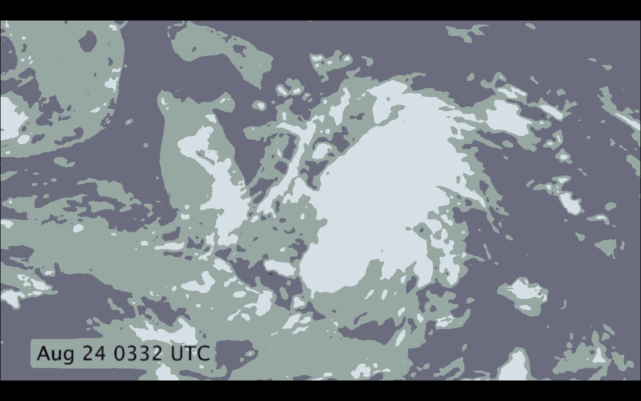

In [8]:
driver("/home/ubuntu/demo/")

https://www.youtube.com/watch?v=C2jPUliVl_4